--> Starting to read in current storm data
--> Completed reading in current storm data (24.98 seconds)


Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.


GeoJSON file with exterior rings created: C:/Downloads/10.geojson


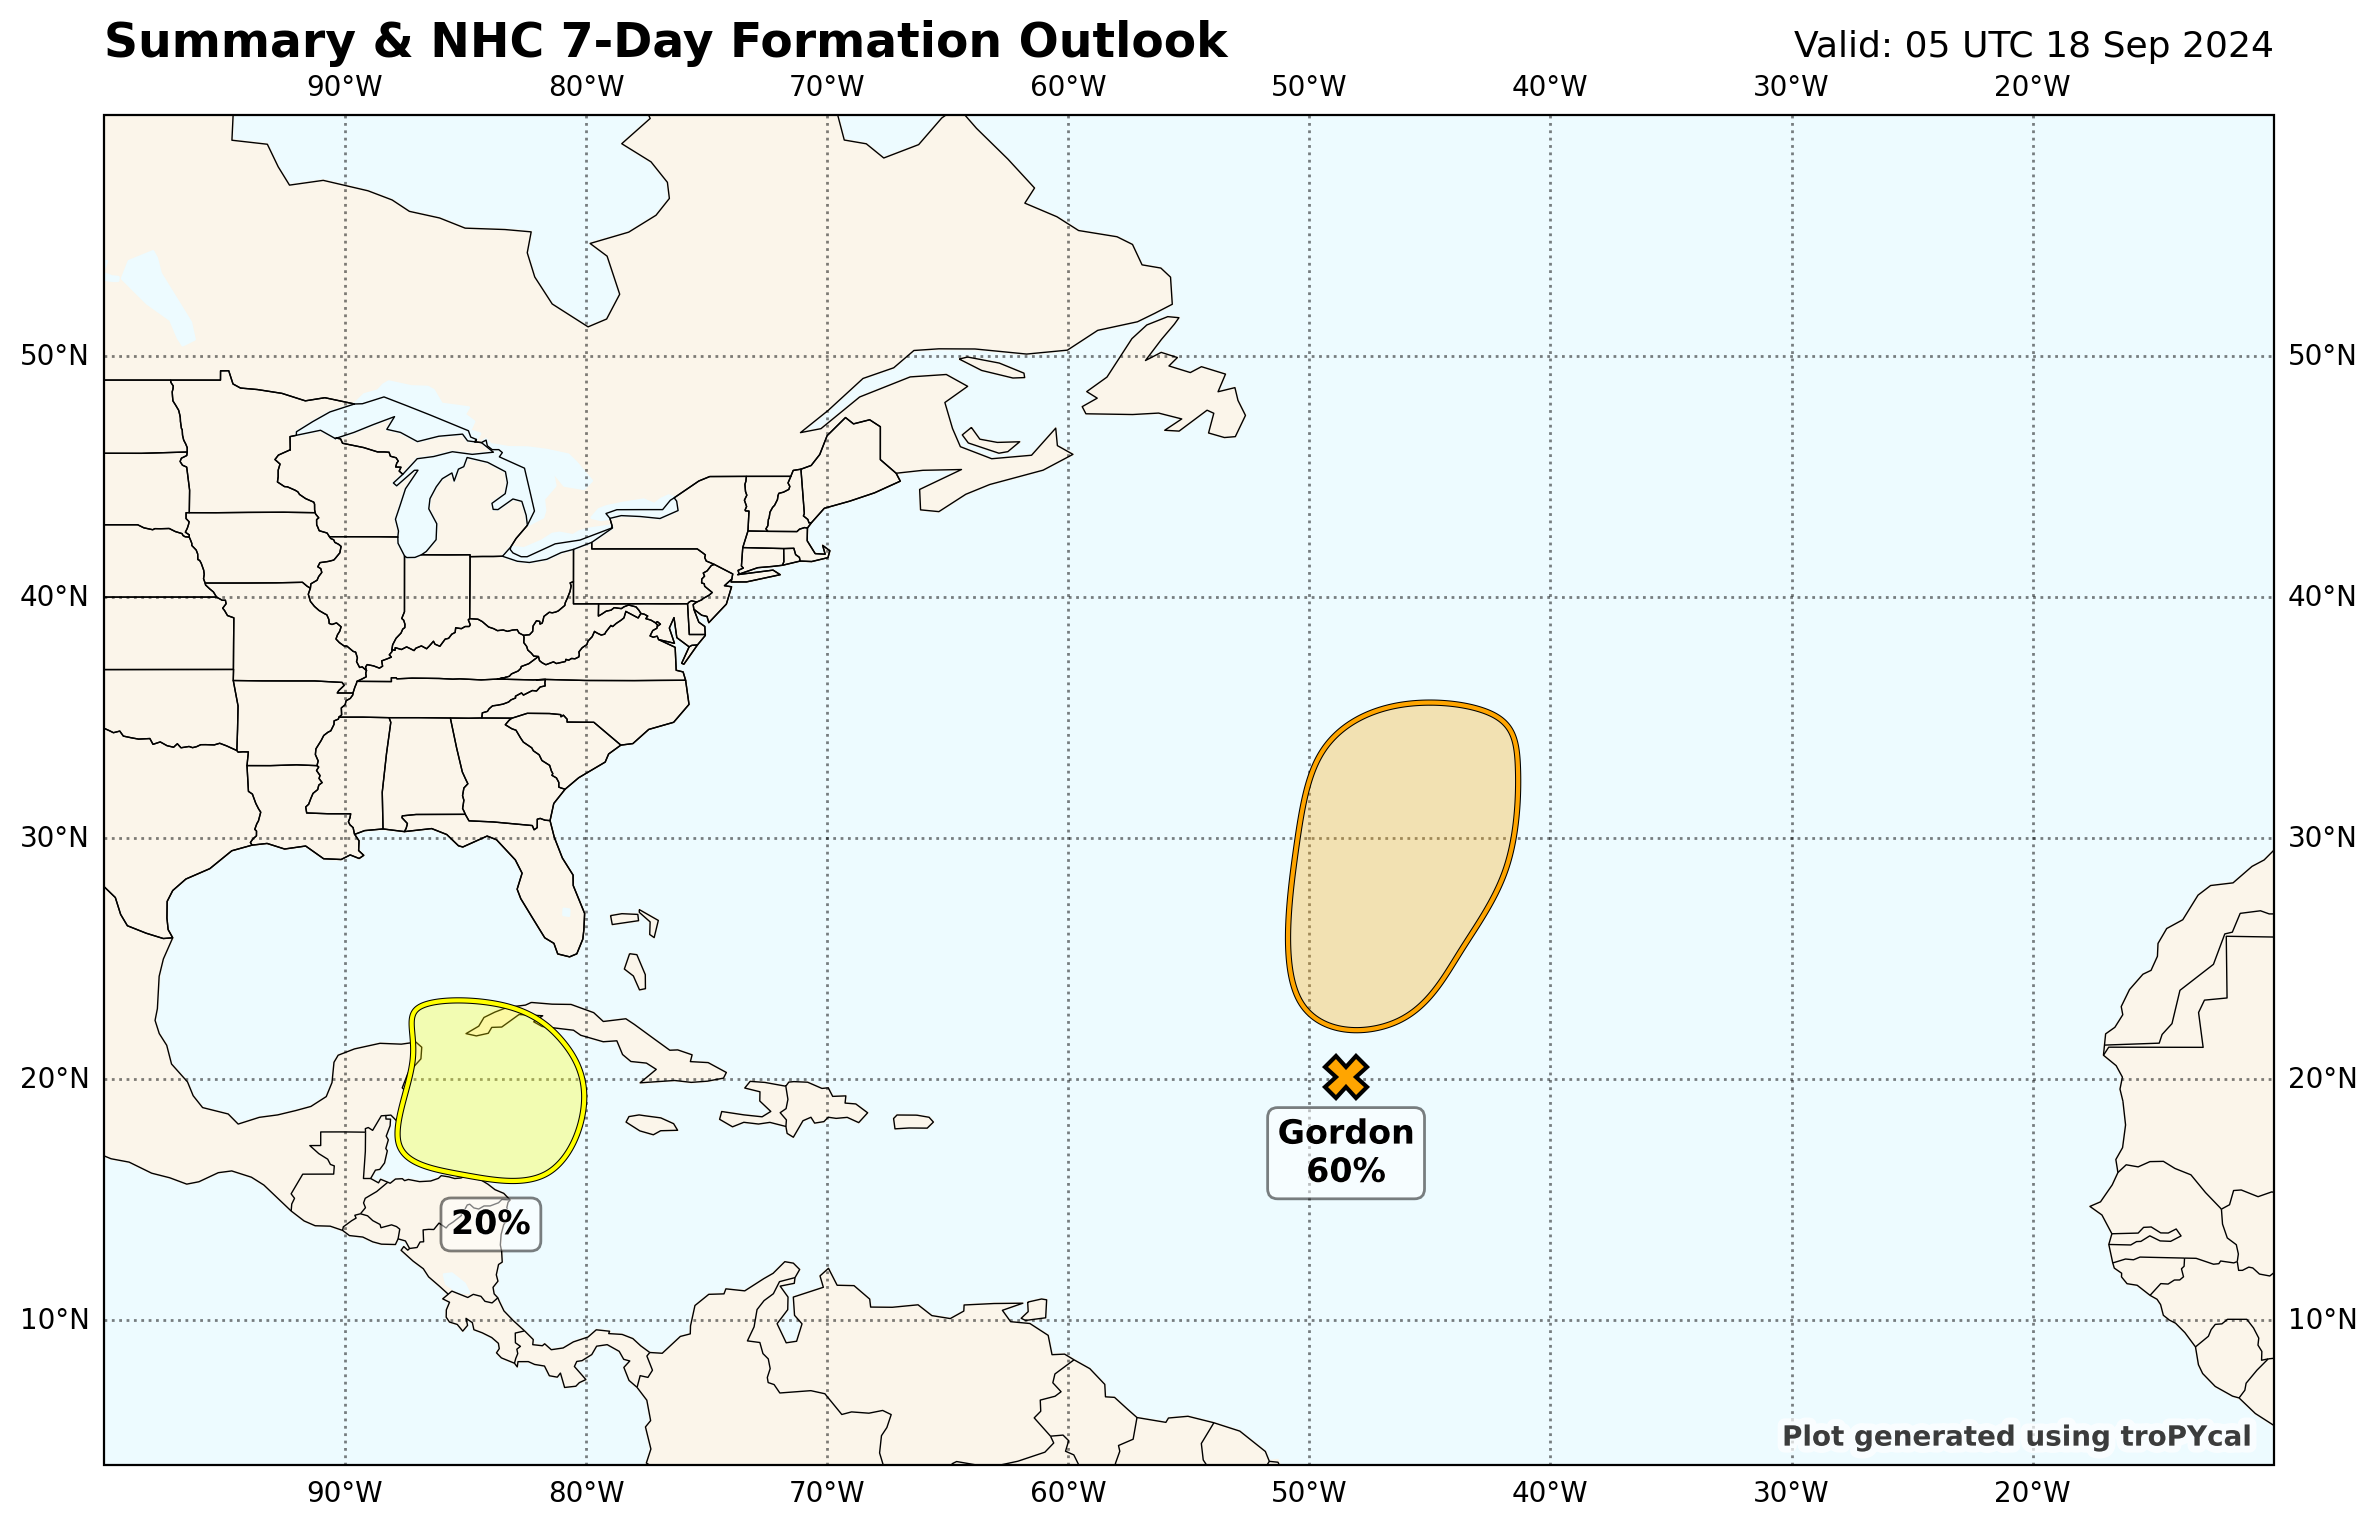

In [1]:
import geojson
import matplotlib.pyplot as plt
from tropycal import realtime

# Initialize the realtime object
realtime_obj = realtime.Realtime()

# Fetch storm data and plot summary with given domain
# We don't display the plot, but we extract the coordinates
storm_plot = realtime_obj.plot_summary(domain={'w': -100, 'e': -10, 's': 4, 'n': 60}, plot=False)

# Now, extract the exterior ring from the plot
# Let's assume the storm_plot contains polygon coordinates we can extract
# If storm_plot provides axes coordinates, we can extract the data from them.

# In case the plot returns a matplotlib object, we extract coordinates from it
def extract_polygon_coordinates_from_plot(storm_plot):
    exterior_rings = []
    for collection in storm_plot.collections:
        for path in collection.get_paths():
            vertices = path.vertices
            exterior_ring = [(lon, lat) for lon, lat in vertices]
            exterior_rings.append(exterior_ring)
    return exterior_rings

# Extract the exterior ring coordinates from the plot
exterior_rings = extract_polygon_coordinates_from_plot(storm_plot)

# Convert the exterior rings into a GeoJSON format
features = []
for ring in exterior_rings:
    # Ensure the polygon is valid (at least 3 points)
    if len(ring) > 2:
        # Create a polygon GeoJSON feature
        polygon = geojson.Polygon([ring])
        feature = geojson.Feature(geometry=polygon, properties={})
        features.append(feature)

# Create a GeoJSON FeatureCollection with all polygons
geojson_data = geojson.FeatureCollection(features)

# Save the GeoJSON file
save_path = "C:/Downloads/10.geojson"
with open(save_path, 'w') as f:
    geojson.dump(geojson_data, f, indent=2)

print(f"GeoJSON file with exterior rings created: {save_path}")


In [2]:
# List of basins to check for active storms
basins = ['north_atlantic', 'east_pacific', 'central_pacific']

# Function to fetch forecast points for all active storms, ignoring invests
def get_forecast_points_geojson():
    features = []

    # Loop through each basin
    for basin in basins:
        try:
            # List all active storms in the basin
            active_storms = realtime_obj.list_active_storms(basin=basin)

            for storm_name in active_storms:
                try:
                    # Retrieve the storm data
                    storm = realtime_obj.get_storm(storm_name)

                    # Ignore Invest storms by checking if the storm is an invest
                    if storm.invest:
                        print(f"Ignoring Invest: {storm_name}")
                        continue  # Skip Invest storms

                    # Get the latest forecast data
                    forecast_data = storm.get_forecast_realtime()

                    # Loop through each forecast point (fhr)
                    for i, lat in enumerate(forecast_data['lat']):
                        lon = forecast_data['lon'][i]
                        forecast_hour = forecast_data['fhr'][i]  # Forecast hour

                        # Create a GeoJSON point for each forecast point
                        point = geojson.Point((lon, lat))
                        feature = geojson.Feature(
                            geometry=point,
                            properties={
                                'storm_name': storm.name,
                                'storm_id': storm.id,
                                'forecast_hour': forecast_hour
                            }
                        )
                        features.append(feature)

                except Exception as e:
                    print(f"Error retrieving data for storm {storm_name}: {e}")

        except Exception as e:
            print(f"Error retrieving active storms for basin {basin}: {e}")

    # Return a GeoJSON FeatureCollection of forecast points
    return geojson.FeatureCollection(features)

# Fetch the forecast points and convert them to GeoJSON
geojson_data = get_forecast_points_geojson()

# Save the GeoJSON data to a file
save_path = "C:/Downloads/active_storms_forecast.geojson"
with open(save_path, 'w') as f:
    geojson.dump(geojson_data, f, indent=2)

print(f"GeoJSON file with forecast points created: {save_path}")

Ignoring Invest: AL072024
GeoJSON file with forecast points created: C:/Downloads/active_storms_forecast.geojson
